In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

sns.set_style('whitegrid')

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Perceptron

In [3]:
df_Train = pd.read_csv("data/train.csv")
df_Test = pd.read_csv("data/test.csv")
df_combine = pd.concat([df_Train, df_Test])#, axis = 1)

| Variable |      Definition      |       Key       |
|----------|:--------------------:|----------------:|
| survival |  Survival            | 0 = No, 1 = Yes |
| sex      |	Sex	| |
| Age |	Age in years	| |
| sibsp |	# of siblings / spouses aboard the Titanic	| |
| parch |	# of parents / children aboard the Titanic	| |
| ticket |	Ticket number	| |
| fare |	Passenger fare	| |
| cabin |	Cabin number	| |
| embarked |	Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton|

In [4]:
df_combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Variable Notes**

**pclass:** A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

**age:** Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp:** The dataset defines family relations in this way...

- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

**parch:** The dataset defines family relations in this way...

- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.


### Info

In [5]:
df_combine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


## Describe

In [6]:
df_combine.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [7]:
df_combine.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [8]:
df_combine.describe(include=['O']) # Only Strings

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


## Survived

Only 38% survived the crash. In this way we must look for correlations between the items we have. Analyze by pivoting features:
- **Sex:** Women make up 35% of the crew. Even with a smaller presence, 74% of them survived;
- **Pclass:** There is a correlation between the survivors, with the classification of their cabins;
- **SibSp and Parch:** These features have zero correlation. It will be necessary to change the data

In [9]:
df_combine['Survived'].mean(), 1 - df_combine['Survived'].mean()

(0.3838383838383838, 0.6161616161616161)

### Sex survived

In [10]:
df_combine[["Sex", "Survived"]].groupby(['Sex']).mean().sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


### Class survived

In [11]:
df_combine[['Pclass', 'Survived']].groupby(['Pclass']).mean().sort_values(by='Survived', ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


### Sibling and Spouse  survived

In [12]:
df_combine[["SibSp", "Survived"]].groupby(['SibSp']).mean().sort_values(by='Survived', ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


###  Parent and Child survived

In [13]:
df_combine[["Parch", "Survived"]].groupby(['Parch']).mean().sort_values(by='Survived', ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000
9,NaN


## Plot for Age

<Figure size 4500x1000 with 0 Axes>

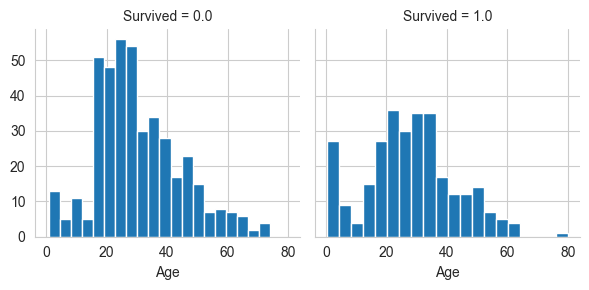

<Figure size 4500x1000 with 0 Axes>

In [14]:
g = sns.FacetGrid(df_combine, col='Survived')
g.map(plt.hist, 'Age', bins=20)
plt.figure(figsize=(45,10))

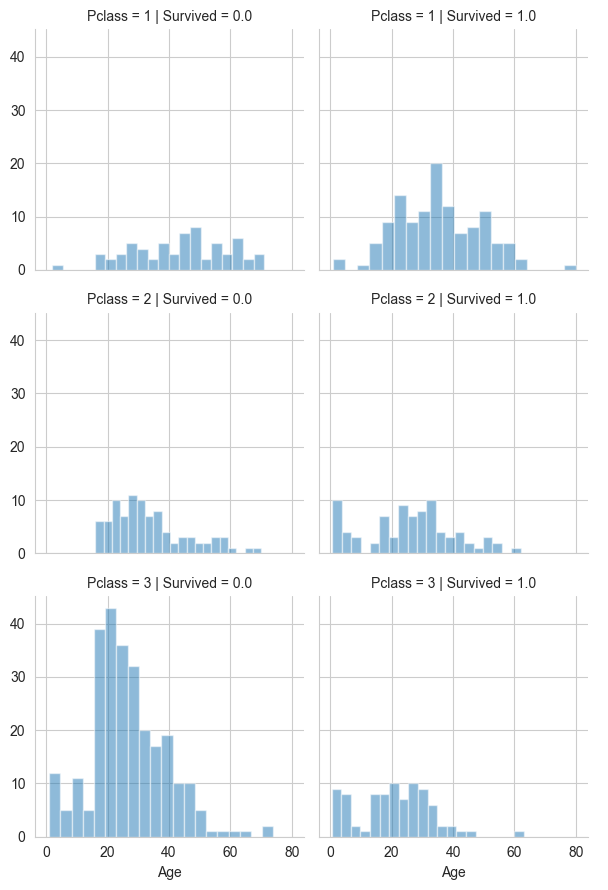

In [15]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(df_combine, col='Survived', row='Pclass')
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

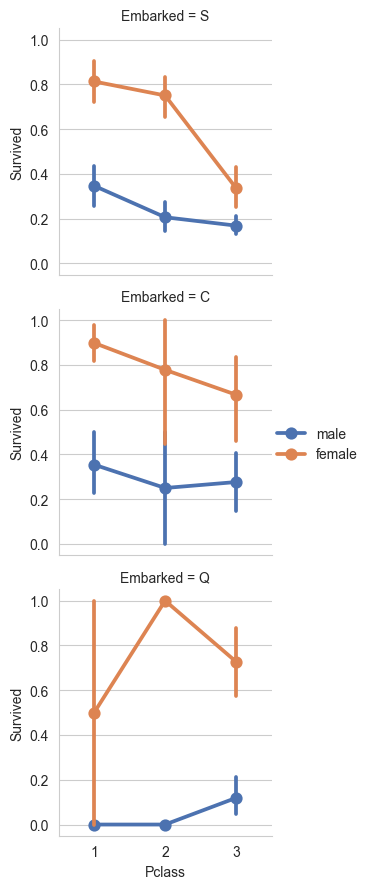

In [16]:
# Determine a order and hue_order based on your data
pclass_order = sorted(df_combine['Pclass'].unique())
sex_order = ['male', 'female']  # or ['female', 'male'], dependendo da sua preferência

grid = sns.FacetGrid(df_combine, row='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order=pclass_order, hue_order=sex_order)
grid.add_legend()


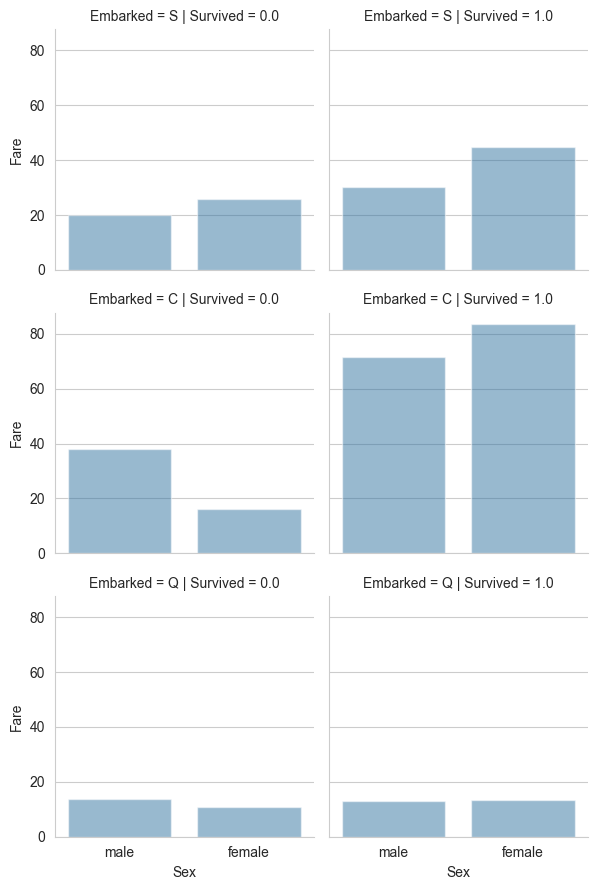

In [17]:
# Determine the order based on your data
sex_order = ['male', 'female']  # Ou ['female', 'male'], dependendo da sua preferência

grid = sns.FacetGrid(df_combine, row='Embarked', col='Survived')
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, errorbar=None, order=sex_order)
grid.add_legend()

### Filter Title

In [18]:
df_combine['Title'] = df_combine['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
df_combine['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [19]:
df_combine['Title'].value_counts()

Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

In [20]:
df_combine['Title'] = [n if n in ["Mr", "Miss", "Mrs", "Master"] else 'Person' for n in df_combine['Title']]
df_combine['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Person'], dtype=object)

In [21]:
df_combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


### Filter Age

In [22]:
df_combine['Age'].fillna(df_combine['Age'].median(), inplace=True)
df_combine['AgeBand'] = pd.cut(df_combine['Age'], 5)
df_combine[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False, observed=True).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.0902, 16.136]",0.550000
1,"(16.136, 32.102]",0.344168
2,"(32.102, 48.068]",0.404255
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [23]:
df_combine.loc[ df_combine['Age'] <= 16, 'Categori_Age'] = 0
df_combine.loc[(df_combine['Age'] > 16) & (df_combine['Age'] <= 32), 'Categori_Age'] = 1
df_combine.loc[(df_combine['Age'] > 32) & (df_combine['Age'] <= 48), 'Categori_Age'] = 2
df_combine.loc[(df_combine['Age'] > 48) & (df_combine['Age'] <= 64), 'Categori_Age'] = 3

df_combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeBand,Categori_Age
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,"(16.136, 32.102]",1.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,"(32.102, 48.068]",2.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,"(16.136, 32.102]",1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,"(32.102, 48.068]",2.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,"(32.102, 48.068]",2.0


In [24]:
df_combine['FamilySize'] = df_combine['SibSp'] + df_combine['Parch'] + 1

df_combine[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [25]:
df_combine['IsAlone'] = 0
df_combine.loc[df_combine['FamilySize'] == 1, 'IsAlone'] = 1

df_combine[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [26]:
df_combine['Age*Class'] = df_combine.Categori_Age * df_combine.Pclass
df_combine.loc[:, ['Age*Class', 'Categori_Age', 'Pclass']].head(10)

,Age*Class,Categori_Age,Pclass
0,3.0,1.0,3
1,2.0,2.0,1
2,3.0,1.0,3
3,2.0,2.0,1
4,6.0,2.0,3
5,3.0,1.0,3
6,3.0,3.0,1
7,0.0,0.0,3
8,3.0,1.0,3
9,0.0,0.0,2


In [27]:
# Calcula o porto mais frequente
freq_port = df_combine['Embarked'].dropna().mode()[0]

# Preenche NaNs com o porto mais frequente
df_combine['Embarked'] = df_combine['Embarked'].fillna(freq_port)

# Seu código original
df_combine[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [28]:
df_combine['FareBand'] = pd.qcut(df_combine['Fare'], 4)
df_combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False, observed=True).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.896]",0.197309
1,"(7.896, 14.454]",0.303571
2,"(14.454, 31.275]",0.441048
3,"(31.275, 512.329]",0.600000


In [29]:
# df_combine.loc[ df_combine['Fare'] <= 7.91, 'Fare'] = 0
# df_combine.loc[(df_combine['Fare'] > 7.91) & (df_combine['Fare'] <= 14.454), 'Fare'] = 1
# df_combine.loc[(df_combine['Fare'] > 14.454) & (df_combine['Fare'] <= 31), 'Fare']   = 2
# df_combine.loc[ df_combine['Fare'] > 31, 'Fare'] = 3
# df_combine['Fare'] = df_combine['Fare'].astype(int)

# df_combine = df_combine.drop(['FareBand'], axis=1)

# df_combine.head(10)

# 1. Preenchendo NaNs
df_combine['Fare'].fillna(df_combine['Fare'].median(), inplace=True)

# 2. Verificando valores infinitos (opcional, mas uma boa prática)
if not np.isfinite(df_combine['Fare']).all():
    # Trate os valores infinitos como você achar melhor. Aqui, estou substituindo-os pela mediana
    median_fare = df_combine['Fare'].median()
    df_combine['Fare'] = df_combine['Fare'].replace([np.inf, -np.inf], median_fare)

# 3. Execute seu código original
df_combine.loc[ df_combine['Fare'] <= 7.91, 'Fare'] = 0
df_combine.loc[(df_combine['Fare'] > 7.91) & (df_combine['Fare'] <= 14.454), 'Fare'] = 1
df_combine.loc[(df_combine['Fare'] > 14.454) & (df_combine['Fare'] <= 31), 'Fare']   = 2
df_combine.loc[ df_combine['Fare'] > 31, 'Fare'] = 3
df_combine['Fare'] = df_combine['Fare'].astype(int)

df_combine = df_combine.drop(['FareBand'], axis=1)

df_combine.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeBand,Categori_Age,FamilySize,IsAlone,Age*Class
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,0,NaN,S,Mr,"(16.136, 32.102]",1.0,2,0,3.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,3,C85,C,Mrs,"(32.102, 48.068]",2.0,2,0,2.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,1,NaN,S,Miss,"(16.136, 32.102]",1.0,1,1,3.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3,C123,S,Mrs,"(32.102, 48.068]",2.0,2,0,2.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,1,NaN,S,Mr,"(32.102, 48.068]",2.0,1,1,6.0
5,6,0.0,3,"Moran, Mr. James",male,28.0,0,0,330877,1,NaN,Q,Mr,"(16.136, 32.102]",1.0,1,1,3.0
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,3,E46,S,Mr,"(48.068, 64.034]",3.0,1,1,3.0
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,2,NaN,S,Master,"(0.0902, 16.136]",0.0,5,0,0.0
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,1,NaN,S,Mrs,"(16.136, 32.102]",1.0,3,0,3.0
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,2,NaN,C,Mrs,"(0.0902, 16.136]",0.0,2,0,0.0


In [30]:
pclass = pd.get_dummies(df_combine['Pclass'], prefix = 'Pclass', drop_first=True)
title = pd.get_dummies(df_combine['Title'], prefix = 'Title', drop_first=True)
sex = pd.get_dummies(df_combine['Sex'], prefix = 'Sex', drop_first=True)
age = pd.get_dummies(df_combine['Age'], prefix = 'Age', drop_first=True)
fare = pd.get_dummies(df_combine['Fare'], prefix = 'Fare', drop_first=True)
embarked = pd.get_dummies(df_combine['Embarked'], prefix = 'Embarked', drop_first=True)
age_class = pd.get_dummies(df_combine['Age*Class'], prefix = 'Age*Class', drop_first=True)

In [31]:
dataTrain = pd.concat([df_combine['PassengerId'], pclass, title, sex, age, fare, embarked, age])

In [48]:
X_train = dataTrain.drop("Survived", axis=1)
Y_train = dataTrain["Survived"]
X_test  = dataTest.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

KeyError: "['Survived'] not found in axis"

# Logistic Regression

In [44]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

NameError: name 'Y_train' is not defined

In [ ]:
coeff_df = pd.DataFrame(dataTrain.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

# Support Vector Machines

In [ ]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

# k-Nearest Neighbors 

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

# Gaussian Naive Bayes

In [ ]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

# Perceptron

In [ ]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

# Linear SVC

In [ ]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

# Stochastic Gradient Descent

In [ ]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

# Decision Tree

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

# Random Forest

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

### Model evaluation

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

In [ ]:
submission = pd.DataFrame({
        "PassengerId": dataTest["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('data/Submission.csv', index = False)